# Project -2 : Counting using OTSU thresholding

White is cluster: 1, With # pixels = 254199
Pink/red is cluster: 3, With # pixels = 242339
Purple is cluster: 2, With # pixels = 303402


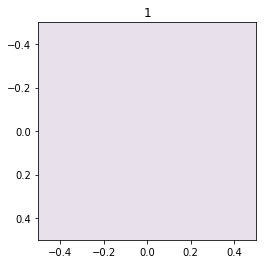

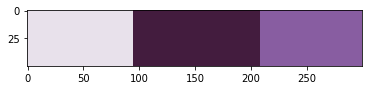

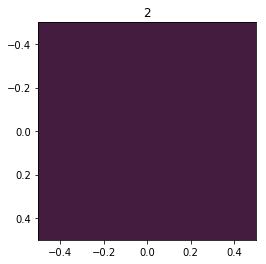

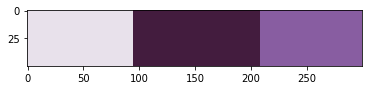

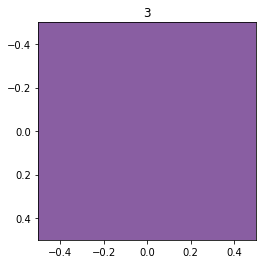

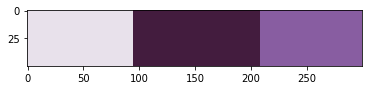

[1000000, 0.254199, 0.242339, 0.303402]

In [2]:
#Testing cell
imageorig = cv2.imread("19_15_1.jpeg")
imageorig_array = imageorig.reshape((imageorig.shape[0] * imageorig.shape[1], 3))
get_pixel_color_counts(imageorig_array,True)

# Installations required (Commented out)

In [ ]:
#!/usr/local/opt/python/bin/python2.7 -m pip install matplotlib==2.0.2

In [ ]:
#!/usr/local/opt/python/bin/python2.7 -m pip install scipy

In [ ]:
#!/usr/local/opt/python/bin/python2.7 -m pip install scikit-learn

In [ ]:
#!/usr/local/opt/python/bin/python2.7 -m pip install scikit-image

In [ ]:
#!pip3 install scikit-image

In [ ]:
#!/usr/local/opt/python/bin/python2.7 -m pip install Pillow

In [ ]:
#!pip2 install tqdm

In [ ]:
#!pip3 install scikit-learn

In [ ]:
#!pip3 install scipy

In [ ]:
#import sys
#print(sys.executable)

In [ ]:
#!brew install openslide
#!/usr/local/opt/python/bin/python2.7 -m pip install openslide-python

In [4]:
#!pip3 install mahotas

  Using cached mahotas-1.4.4.tar.gz
  Running setup.py bdist_wheel for mahotas ... done
  Stored in directory: /Users/asmaaaljuhani/Library/Caches/pip/wheels/76/87/24/2ffb31d56c7d1f21175c006697cb7e305a43fe0be0891cfdc8
Successfully built mahotas


## Configuration file [Run this]

In [1]:
import os

# directory of the config file
CURRENT_DIR = os.path.realpath('.')

DEFAULT_FILENAME = 'slide'

IMAGE_FOLDER_PATH = CURRENT_DIR+"/input"

OUTPUT_FOLDER_PATH = CURRENT_DIR+"/output"

IMG_FORMAT = 'jpeg'

TILE_SIZE = 1000

OVERLAP = 0

LIMIT_BOUNDS = True

QUALITY = 100

NUM_WORKERS = 12

ONLY_LAST = True

SAVE_REJECTED = False

DONT_REJECT = True

# increase this to reject more
REJECT_THRESHOLD = 200

ROTATE = False

MAX_WHITE_SIZE = (TILE_SIZE*TILE_SIZE)/2

def ver_print(string, value):
    print(string + " {0}".format(value))

## Preprocessing and tilling [Run this]

In [2]:
import glob
import os
from tqdm import tqdm
import PIL
import cv2
from PIL import Image
from tiler import WholeSlideTiler

def main():
    files = glob.glob(IMAGE_FOLDER_PATH + '/*.svs')
    for slidepath in tqdm(files):
        basename = os.path.splitext(os.path.basename(slidepath))[0]
        basepath = os.path.join(OUTPUT_FOLDER_PATH, basename)
        WholeSlideTiler(slidepath, basepath, IMG_FORMAT, TILE_SIZE, OVERLAP, LIMIT_BOUNDS, ROTATE,
                        QUALITY, NUM_WORKERS, ONLY_LAST).run()


if __name__ == '__main__':
    main()


Tiling slide: wrote 1110/1110 tiless]
Tiling macro: wrote 2/2 tiles
Tiling thumbnail: wrote 2/2 tiles


Tiling completed on slide in:  <time here>
Tiling completed on macro in:  <time here>
Tiling completed on thumbnail in:  <time here>


100%|██████████| 1/1 [00:47<00:00, 47.95s/it]


## Method: Normalizing [Run This]

In [3]:
from __future__ import division

import glob

import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image 
from numpy import random
import os


def safe_ln(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))


def normalize_staining(I=None):
    I = I.astype(np.float64)
    Io = 240
    beta = 0.15
    alpha = 1
    HERef = np.array([[0.5626, 0.2159], [0.7201, 0.8012], [0.4062, 0.5581]])
    maxCRef = np.array([1.9705, 1.0308])

    (h, w, c) = np.shape(I)
    I = np.reshape(I, (h * w, c), order='F')

    # Step 1. Convert RGB to OD.
    OD = - np.log((I + 1) / Io) # optical density where each channel in the image is normalized to values between [0, 1]

    # Step 2. Remove data with OD intensity less than beta
    ODhat = (OD[(np.logical_not((OD < beta).any(axis=1))), :])

    # Step 3. Calculate SVD on the OD tuples
    cov = np.cov(ODhat, rowvar=False)
    (W, V) = np.linalg.eig(cov)

    # Step 4. create plane from the SVD directions
    # corresponding to the two largest singular values
    Vec = - np.transpose(np.array([V[:, 1], V[:, 0]]))

    # Step 5. Project data onto the plane and normalize to unit Length
    That = np.dot(ODhat, Vec)

    # Step 6. Calculate angle of each point w.r.t the first SVD direction
    phi = np.arctan2(That[:, 1], That[:, 0])

    # Step 7. Find robust extremes (some alpha th and (100 - alpha th) percentiles of the angle
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)
    vMin = np.dot(Vec, np.array([np.cos(minPhi), np.sin(minPhi)]))
    vMax = np.dot(Vec, np.array([np.cos(maxPhi), np.sin(maxPhi)]))
    if vMin[0] > vMax[0]:
        HE = np.array([vMin, vMax])
    else:
        HE = np.array([vMax, vMin])

    HE = np.transpose(HE)

    # Step 8. Convert extreme values back to OD space
    Y = np.transpose(np.reshape(OD, (h * w, c)))
    C = np.linalg.lstsq(HE, Y,rcond=None)
    maxC = np.percentile(C[0], 99, axis=1)
    C = C[0] / maxC[:, None]
    C = C * maxCRef[:, None]
    Inorm = Io * np.exp(- np.dot(HERef, C))
    Inorm = np.reshape(np.transpose(Inorm), (h, w, c), order='F')
    Inorm = np.clip(Inorm, 0, 255)
    Inorm = np.array(Inorm, dtype=np.uint8)

    return Inorm  # ,H,E


## Normalizing All Tiles [Run This]

In [4]:
def main():

    list_img = glob.glob(glob.glob("output/*/")[0]+"slide/*/*.jpeg")
    for filename in list_img: #WILL TAKE SOME TIME
        fileout = os.path.splitext(filename)[0]+"_normal.jpeg"
        img = cv2.imread(filename)
        img = img.astype(np.float64)

        img = normalize_staining(img)

        cv2.imwrite(fileout, img)
        # Uncomment for tile display
        #img_show = Image.open(fileout)
        #img_show.show()  
        
main()


### METHOD: Possible Clustering evaluation (Feasible to run only on re-sized image, as entire image causes kernel to crash) [Run this IF silhoutte analysis needs to be performed]

In [13]:
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

###########Helper Functions##################
def sil_best_clusters(image_to_clust):
 bestSilhouette = -1
 bestClusters = 0;
 range_of_k = 3

 for clusters in range(2, range_of_k):
	 # Cluster colours
	 clt = KMeans(n_clusters = clusters)
	 clt.fit(image_to_clust)

	 # Validate clustering result
	 silhouette = metrics.silhouette_score(image_to_clust, clt.labels_, metric='euclidean')

	 # Find the best one
	 if silhouette > bestSilhouette:
		 bestSilhouette = silhouette;
		 bestClusters = clusters;
        
 return(bestClusters)
############################################

#print("Ideal number of clusters: " + str(sil_best_clusters(imageresized_array))) #Running only with resized image

### METHOD: Clustering dominant colours with K-Means, and annotating all pixels with color centroids [Run This]
#### K-Means clustering finds 3 color clusters of pixels, summing the RGB value and ranking cluster centroids gives us white, pink and purple clusters (high sum(RGB) = white, low sum(RGB) = purple and middle sum(RGB) = pink

In [1]:
# Some code used from Adrian Rosebrock's k-means to find dominant colors tutorial
from sklearn.cluster import KMeans
from collections import Counter
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
import scipy.spatial.distance
from scipy.spatial import distance
import numpy as np
from scipy.stats import rankdata
import cv2
import matplotlib.pyplot as plt
from __future__ import division

###########Helper Functions##################
def centroid_histogram(clt):
     # grab the number of different clusters and create a histogram
     # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

     # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

     # return the histogram
    return hist

def plot_colors(hist, centroids):
	# initialize the bar chart representing the relative frequency
	# of each of the colors
	bar = np.zeros((50, 300, 3), dtype = "uint8")
	startX = 0

	# loop over the percentage of each cluster and the color of
	# each cluster
	for (percent, color) in zip(hist, centroids):
		# plot the relative percentage of each cluster
		endX = startX + (percent * 300)
		cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
			color.astype("uint8").tolist(), -1)
		startX = endX
	
	# return the bar chart
	return bar


#pink = [255,192,203]
#purple = [128,0,128]
#white = [255,255,255]
def ClusterIndicesNumpy(arr, clustNum, labels_array): #numpy 
    return(arr[np.where(labels_array == clustNum)[0]])
     

def get_pixel_color_counts(img_arr,showdetails): 
    # Clusters the pixels
    clt = KMeans(n_clusters = 3)
    clt.fit(img_arr)
    # Find cluster labels for each pixel
    labels = clt.predict(img_arr)
    
    # Remove "outliers" that don't belong to any pertinent color, i.e non-specific colors (top 20% most distant pixels from cluster centroids)
    ranks0 =((rankdata(distance.cdist(ClusterIndicesNumpy(img_arr,0, labels), [clt.cluster_centers_[0]], 'euclidean')) - 1).astype(int))
    ranks1 =((rankdata(distance.cdist(ClusterIndicesNumpy(img_arr,1, labels), [clt.cluster_centers_[1]], 'euclidean')) - 1).astype(int))
    ranks2 =((rankdata(distance.cdist(ClusterIndicesNumpy(img_arr,2, labels), [clt.cluster_centers_[2]], 'euclidean')) - 1).astype(int))
    newranks0 = ranks0<round(len(ranks0)*0.80)
    newranks1 = ranks1<round(len(ranks1)*0.80)
    newranks2 = ranks2<round(len(ranks2)*0.80)
    
    labels0 = labels[np.where(labels == 0)[0]]
    labels1 = labels[np.where(labels == 1)[0]]
    labels2 = labels[np.where(labels == 2)[0]]
    
    newlabels0 = labels0[newranks0]
    newlabels1 = labels1[newranks1]
    newlabels2 = labels2[newranks2]
    
    newlabels =  np.concatenate([newlabels0, newlabels1, newlabels2])

    # How many pixels in each cluster originally
    Num_pix = Counter(labels)
    # How many pixels in each cluster after removing non-specific colors
    Num_pix_refined = Counter(newlabels)
    
    # Debugging print statements
    #print(Counter(labels))
    #print(clt.cluster_centers_)

    # Get the sum of R,G,B values for cluster centroids
    myList = [sum(item) for item in np.array(clt.cluster_centers_)]

    # Rank the sum of R,G,B values for cluster centroids (Higher the value, more proclivity for white, lower value will be dark purple, middle value will be pink/red)
    ranks =((rankdata(myList) - 1).astype(int))

    if showdetails:    
    # Print cluster and member cluster details
        print("White is cluster: "+ str(np.where(np.isin(ranks,[2]))[0][0]+1)+", With # pixels = "+ str(Num_pix_refined[np.where(np.isin(ranks,[2]))[0][0]]))
        print("Pink/red is cluster: "+ str(np.where(np.isin(ranks,[1]))[0][0]+1)+", With # pixels = "+ str(Num_pix_refined[np.where(np.isin(ranks,[1]))[0][0]]))
        print("Purple is cluster: "+ str(np.where(np.isin(ranks,[0]))[0][0]+1)+", With # pixels = "+ str(Num_pix_refined[np.where(np.isin(ranks,[0]))[0][0]]))

    #Show cluster colors and bar histogram
        hist = centroid_histogram(clt)
        bar = plot_colors(hist, clt.cluster_centers_)
        zipped = zip (hist, clt.cluster_centers_)
        hist, clt.cluster_centers = zip(*zipped)
        i=0
        for rgb in (clt.cluster_centers_).round():
            plt.title(i+1)
            plt.imshow([[(rgb/255)]])
            plt.show()
            i+=1

            plt.imshow(bar)
            plt.show()
    
    total_pixels = len(labels)
    return([total_pixels,Num_pix_refined[np.where(np.isin(ranks,[2]))[0][0]]/total_pixels,Num_pix_refined[np.where(np.isin(ranks,[1]))[0][0]]/total_pixels,Num_pix_refined[np.where(np.isin(ranks,[0]))[0][0]]/total_pixels])
#############################################
#Uncomment for testing
#imageorig = cv2.imread("test_tiny.jpg")
#imageorig_array = imageorig.reshape((imageorig.shape[0] * imageorig.shape[1], 3))
#total,white,pink,purple = get_pixel_color_counts(imageorig_array,True)

## Loading, resizing and processing tiles to annotate pixels with color [Run This]
### "Purpleness" is decided by unsupervised k-means clustering to find dominant colors
#### All pixels in the "purple" cluster are considered "purple or cancerous"

In [6]:
# Load the image
from skimage import io, color
import cv2
import numpy as np
import os

white_all_tiles = []
pink_all_tiles = []
white_all_tiles = []
purple_all_tiles = []
total_all_tiles = []

list_img = glob.glob(glob.glob("output/*/")[0]+"slide/*/*_normal.jpeg")

for filename in list_img: #WILL TAKE VERY LONG
       
    imageorig = cv2.imread(filename)
    print("Working on "+ os.path.basename(filename))
    # Resize it
    h, w, _ = imageorig.shape
    w_new = int(100 * w / max(w, h) )
    h_new = int(100 * h / max(w, h) )
    image = cv2.resize(imageorig, (w_new, h_new));
    # Using original image (possible to use resized image above for faster processing)
    # Reshape image to be a list of pixels
    imageorig_array = imageorig.reshape((imageorig.shape[0] * imageorig.shape[1], 3))
    total,white,pink,purple = get_pixel_color_counts(imageorig_array,False)
    total_all_tiles.extend([total])
    white_all_tiles.extend([white])
    pink_all_tiles.extend([pink])
    purple_all_tiles.extend([purple])




    
    
    
    
#convert color space from RGB to LAB
#image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)


# This line is to set L values to 0 and keep A and B
#image[:,:,0]= 0
#print(image)

#cv2.imshow('image',image)
#cv2.waitKey(0)
#print(image[0][0])


Working on 10_10_1_normal.jpeg
Working on 10_11_1_normal.jpeg
Working on 10_12_1_normal.jpeg
Working on 10_5_1_normal.jpeg
Working on 10_6_1_normal.jpeg
Working on 10_7_1_normal.jpeg
Working on 10_8_1_normal.jpeg
Working on 10_9_1_normal.jpeg
Working on 11_10_1_normal.jpeg
Working on 11_11_1_normal.jpeg
Working on 11_5_1_normal.jpeg
Working on 11_6_1_normal.jpeg
Working on 11_7_1_normal.jpeg
Working on 11_8_1_normal.jpeg
Working on 11_9_1_normal.jpeg
Working on 12_10_1_normal.jpeg
Working on 12_11_1_normal.jpeg
Working on 12_5_1_normal.jpeg
Working on 12_6_1_normal.jpeg
Working on 12_7_1_normal.jpeg
Working on 12_8_1_normal.jpeg
Working on 12_9_1_normal.jpeg
Working on 13_10_1_normal.jpeg
Working on 13_11_1_normal.jpeg
Working on 13_6_1_normal.jpeg
Working on 13_7_1_normal.jpeg
Working on 13_8_1_normal.jpeg
Working on 13_9_1_normal.jpeg
Working on 14_10_1_normal.jpeg
Working on 14_11_1_normal.jpeg
Working on 14_6_1_normal.jpeg
Working on 14_7_1_normal.jpeg
Working on 14_8_1_normal.jpeg

## Plot histograms of ratio of white, pink and purple pixels over total number of pixels across tiles [Run This]

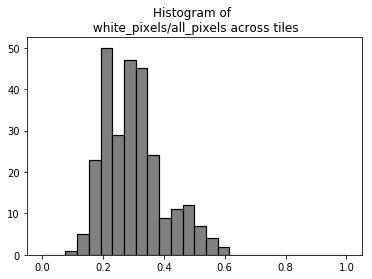

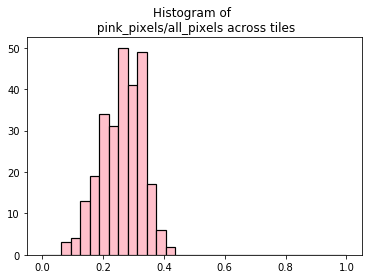

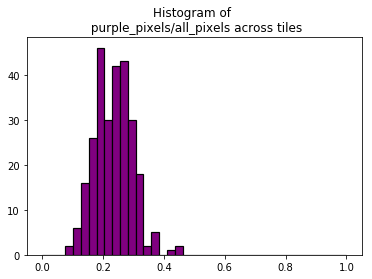

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(white_all_tiles, bins='auto',color = "gray",edgecolor='black', linewidth=1.2,range=[0, 1])  # arguments are passed to np.histogram
plt.title("Histogram of \n white_pixels/all_pixels across tiles")
plt.show()
plt.hist(pink_all_tiles, bins='auto',color = "pink",edgecolor='black', linewidth=1.2,range=[0, 1])  # arguments are passed to np.histogram
plt.title("Histogram of \n pink_pixels/all_pixels across tiles")
plt.show()
plt.hist(purple_all_tiles, bins='auto',color = "purple",edgecolor='black', linewidth=1.2,range=[0, 1])  # arguments are passed to np.histogram
plt.title("Histogram of \n purple_pixels/all_pixels across tiles")
plt.show()

## Find sum of purple/non-purple over all tiles and estimate total cancer [Run This]

In [9]:
#Total pixels across all tiles
total_pixels_of_tiles = sum(total_all_tiles)
#Total purple pixels across all tiles (((ratio of purple/all pixels) * all pixels) in each tile)
total_purple_pixels_of_tiles = sum([a*b for a,b in zip(purple_all_tiles,total_all_tiles)])
#Total cancer is total purple pixels/total all pixels
print("Total cancer: "+ str(total_purple_pixels_of_tiles/total_pixels_of_tiles))

Total cancer: 0.235162862454


## Test of various ways to annotate pink, white and purple pixels (Commented out)

In [ ]:
#from scipy.spatial import distance
#import numpy as np
#from scipy.stats import rankdata

#pink = [255,192,203]
#purple = [128,0,128]
#white = [255,255,255]

#a = np.array([pink,white,purple])
#b = np.array([[232.21804653,225.47207084,235.11397529],[67.25475005,28.18760198,62.60561427],[136.8342103,93.84363329,161.96761943]])
#d = distance.cdist(a, b, 'euclidean')
#print(d[:,2])
#values = d[:,2]

#myList = [sum(item) for item in b]
#print((rankdata(myList) - 1).astype(int))
#myList = [501,2,500,3]
#print(np.argsort(myList))
#print([c[0] for c in sorted(enumerate(myList),key=lambda i:i[1])])
#print(np.sum(b[0]))
#print(np.sum(b[1]))
#print(np.sum(b[2]))
#print(np.argmin(values))
#print(distance.euclidean(a[1],b[0]))

## Possible way of counting colors per pixel (if exact color range is known) (Commented out)

In [ ]:
#from PIL import Image , ImageStat


#im = Image.open("112_16_1.jpeg").convert('L')
#stat = ImageStat.Stat(im)
#print("Read RMS brightness of image: ")
#print(stat.extrema)
#print(stat.count)
#print(stat.sum)


#black = 0
#red = 0

#for pixel in im.getdata():
    #if pixel == (0, 0, 0): # if your image is RGB (if RGBA, (0, 0, 0, 255) or so
       # black += 1
    #else:
     #   red += 1
#print('black=' + str(black)+', red='+str(red))

In [ ]:
## Possible way of counting colors per pixel (if exact color range is known) (Commented out)

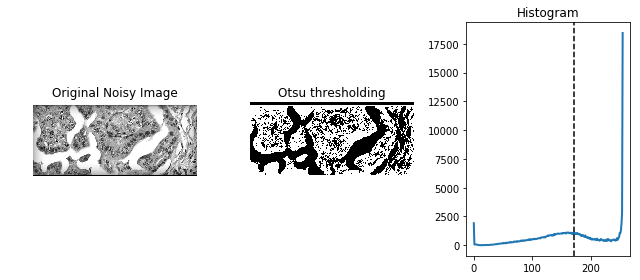

Number of objects found: 561


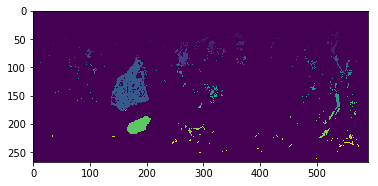

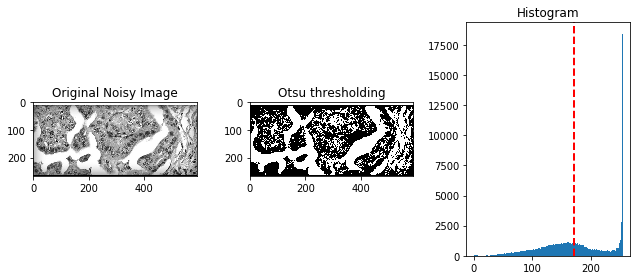

Number of objects found: 1741


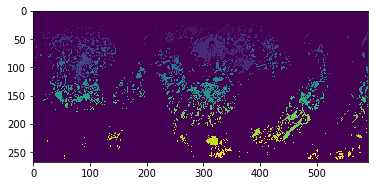

In [5]:
#Featured at http://www.scipy-lectures.org/packages/scikit-image/auto_examples/plot_threshold.html
#Featured at http://www.meccanismocomplesso.org/en/opencv-python-otsu-binarization-thresholding/
#Features at https://github.com/luispedro/python-image-tutorial/blob/master/Segmenting%20cell%20images%20(fluorescent%20microscopy).ipynb

import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure
import mahotas as mh
from pylab import imshow, show

img = cv2.imread('Small_test_images_jpeg/test_tiny.jpg',0)

######################Otsu_thresholding_option1######################
val = filters.threshold_otsu(img)
hist, bins_center = exposure.histogram(img)
plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.title('Original Noisy Image')
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.title('Otsu thresholding')
plt.imshow(img < val, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.title('Histogram')
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')
plt.tight_layout()
plt.show()
##################################################################
########################Counting cells with connected component labeling with otsu option1########################
labeled, nr_objects = mh.label(img < val)
print("Number of objects found: "+ str(nr_objects))
imshow(labeled)
show()
#plt.imshow(labeled)

#plt.jet()

##################################################################
######################Otsu_thresholding_option2############################################
ret, imgf = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(figsize=(9, 4))
plt.subplot(131), plt.imshow(img,cmap = 'gray')
plt.title('Original Noisy Image')#, plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(imgf,cmap = 'gray')
plt.title('Otsu thresholding')#, plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.hist(img.ravel(), 256)
plt.axvline(x=ret, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram')#, plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()
##################################################################
########################Counting cells with connected component labeling otsu option2########################
labeled, nr_objects = mh.label(imgf)
print("Number of objects found: "+ str(nr_objects))
imshow(labeled)
show()
#plt.imshow(labeled)

#plt.jet()

##################################################################